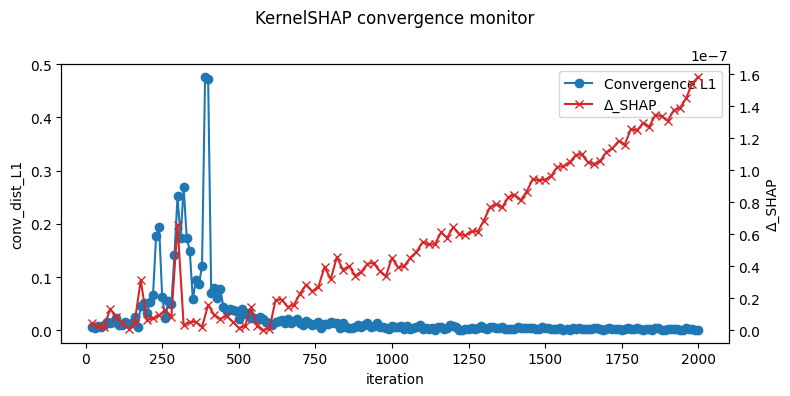

In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt


# ------------------------------------------------------------------ #
# 1.  Parse log, de-duplicate by overwriting on the same iteration   #
# ------------------------------------------------------------------ #
def load_metrics_nodupe(log_path):
    conv_dict, delta_dict = {}, {}          # {iter: value}

    with Path(log_path).open() as fp:
        for ln in fp:
            rec = json.loads(ln)
            it = rec["iter"]
            if "conv_dist_L1" in rec:
                conv_dict[it] = rec["conv_dist_L1"]
            if "delta_shap" in rec:
                delta_dict[it] = rec["delta_shap"]

    # sort into lists
    it_conv   = sorted(conv_dict)
    conv_vals = [conv_dict[i]   for i in it_conv]

    it_delta  = sorted(delta_dict)
    delta_vals= [delta_dict[i]  for i in it_delta]

    return (it_conv, conv_vals), (it_delta, delta_vals)


# ------------------------------------------------------------------ #
# 2.  Plot with shared x, two y-axes                                  #
# ------------------------------------------------------------------ #
def plot_conv_delta(conv, delta, title=None):
    it_conv, conv_vals   = conv
    it_delta, delta_vals = delta

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("conv_dist_L1")
    ax1.plot(it_conv, conv_vals, marker="o", label="Convergence L1")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Δ_SHAP")
    ax2.plot(it_delta, delta_vals, marker="x", color="tab:red", label="Δ_SHAP")

    # legend combining both axes
    lines  = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    return fig


# ------------------------------------------------------------------ #
# Example usage                                                      #
# ------------------------------------------------------------------ #
log_file = "monitor_log-5.jsonl"          # your log path
conv, delta = load_metrics_nodupe(log_file)

fig = plot_conv_delta(conv, delta, title="KernelSHAP convergence monitor")
plt.show()


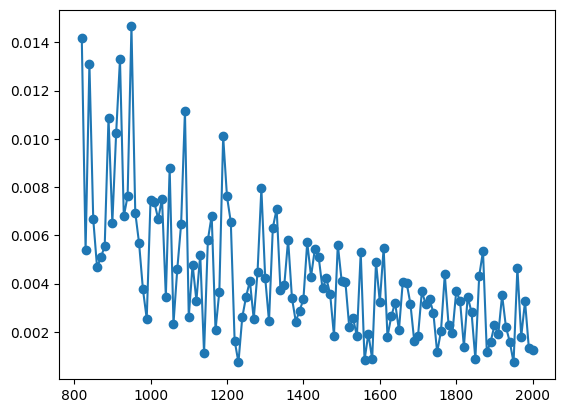

In [2]:
it_conv, conv_vals = conv
plt.plot(it_conv[80:], conv_vals[80:], marker="o", label="Convergence L1")

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(20, 2001, 20)
conv_distances = []
deltas = []
condition_numbers = []

from sklearn.linear_model import LinearRegression as LinReg

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007279]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n=  20: delta=2.33e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.03e+04

n=  40: delta=2.33e-10, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.41e+04

n=  60: delta=2.33e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.43e+04

n=  80: delta=1.63e-09, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.50e+04

n= 100: delta=9.31e-10, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, ph


=== Investigating around iteration 250==


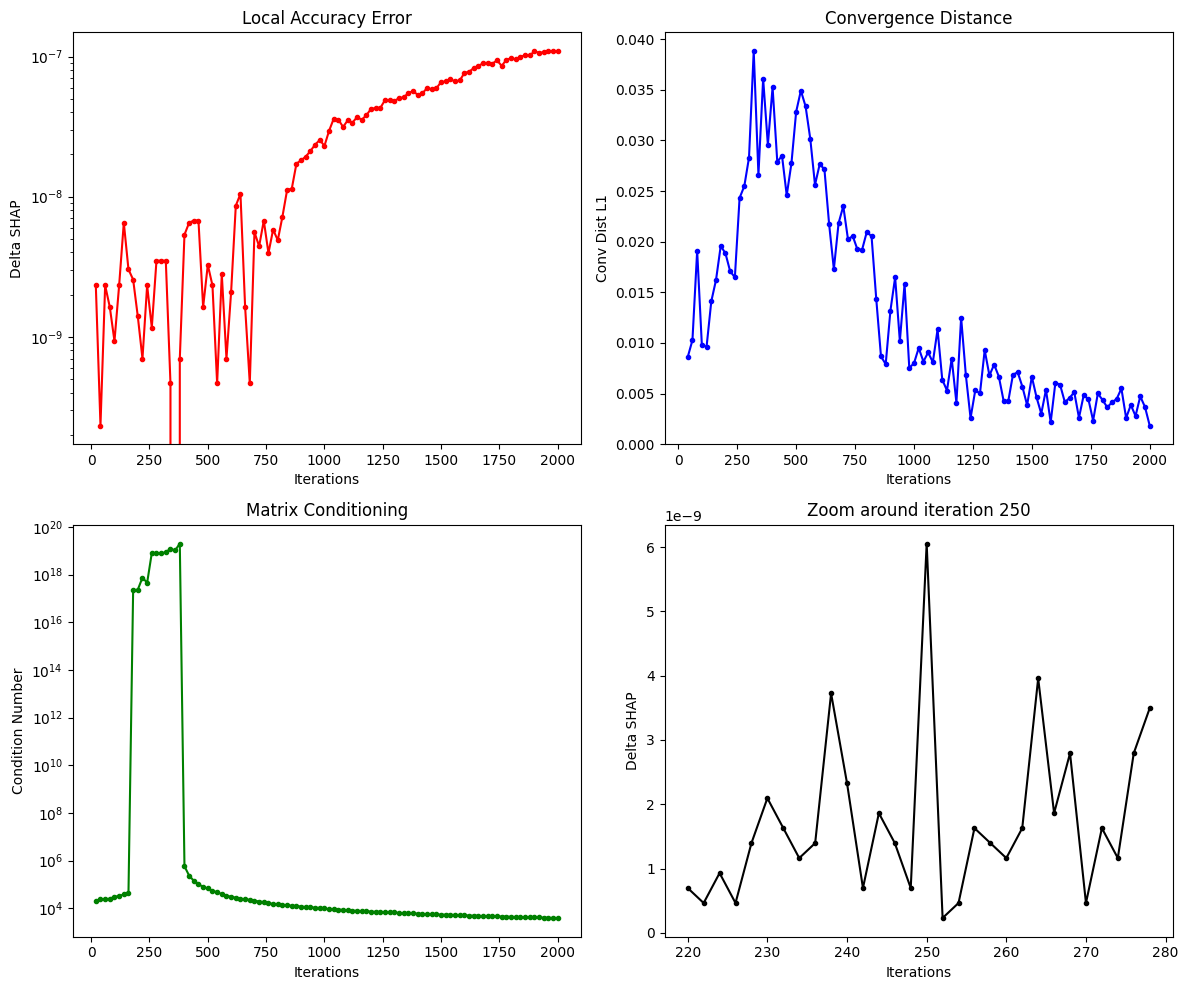


=== Additional Analysis ===
Number of unique samples: 1950
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 176
Samples with exactly 5 features active: 34
Samples with exactly 10 features active: 19
Samples with exactly 50 features active: 2
Samples with exactly 100 features active: 1
Samples with exactly 383 features active: 149

=== Samples around position 170 ===
Sample 160: sum=383, y=0.007214, w=1
Sample 161: sum=363, y=0.006553, w=1
Sample 162: sum=56, y=0.000000, w=1
Sample 163: sum=272, y=0.005593, w=1
Sample 164: sum=122, y=0.001498, w=1
Sample 165: sum=2, y=0.000000, w=1
Sample 166: sum=333, y=0.007090, w=1
Sample 167: sum=156, y=0.005760, w=1
Sample 168: sum=340, y=0.006493, w=1
Sample 169: sum=380, y=0.007226, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=1, y=0.000000, w=1
Sample 172: sum=339, y=0.007196, w=1
Sample 173: sum=46, y=0.000000, w=1
Sample 174: sum=383, y=0.007214, w=1
Sampl

In [ ]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Investigate around iteration 250
print("\n=== Investigating around iteration 250==")
window = list(range(220, 280, 2))  # every 2 iterations to save time
deltas_window = []
for n in window:
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    delta = abs(y[0].item() - (phi0 + phis.sum().item()))
    deltas_window.append(delta)

axes[1,1].plot(window, deltas_window, 'k.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Delta SHAP')
axes[1,1].set_title('Zoom around iteration 250')

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):visualize-LinRegSurrogate.ipynb
# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [5]:
print("condition numbers:")
print(len(condition_numbers))
print(checkpoints)
print([(i, condition_numbers[i//20-1]) for i in checkpoints])

condition numbers:
100
range(20, 2001, 20)
[(20, 20319.80772988343), (40, 24137.991763569516), (60, 24331.523905354145), (80, 24995.06357091029), (100, 30788.607000158623), (120, 32394.02818898437), (140, 38479.74672383023), (160, 42375.91895019986), (180, 2.1788459472021834e+17), (200, 2.338189121121193e+17), (220, 7.447066486103569e+17), (240, 4.531441901467369e+17), (260, 8.072516502073389e+18), (280, 7.916813038413586e+18), (300, 7.702547812203298e+18), (320, 8.738990907127635e+18), (340, 1.202966041035273e+19), (360, 1.032814916676174e+19), (380, 2.001395830032993e+19), (400, 582127.6509725752), (420, 235423.00266344455), (440, 142661.51623749753), (460, 105019.73195471348), (480, 78207.42935371687), (500, 68509.34295603403), (520, 53857.71585408218), (540, 47441.96903768006), (560, 39443.95548982118), (580, 34361.748024847584), (600, 30289.266182645777), (620, 28063.053264306203), (640, 25421.240390397434), (660, 23918.942184569612), (680, 22661.983774013785), (700, 21121.2742915

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(160, 180, 1)
conv_distances = []
deltas = []
condition_numbers = []

from sklearn.linear_model import LinearRegression as LinReg

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007279]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n= 160: delta=3.03e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.24e+04

n= 161: delta=1.63e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.24e+04

n= 162: delta=2.56e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.31e+04

n= 163: delta=6.98e-10, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.32e+04

n= 164: delta=1.63e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214,


=== Investigating around iteration 250==


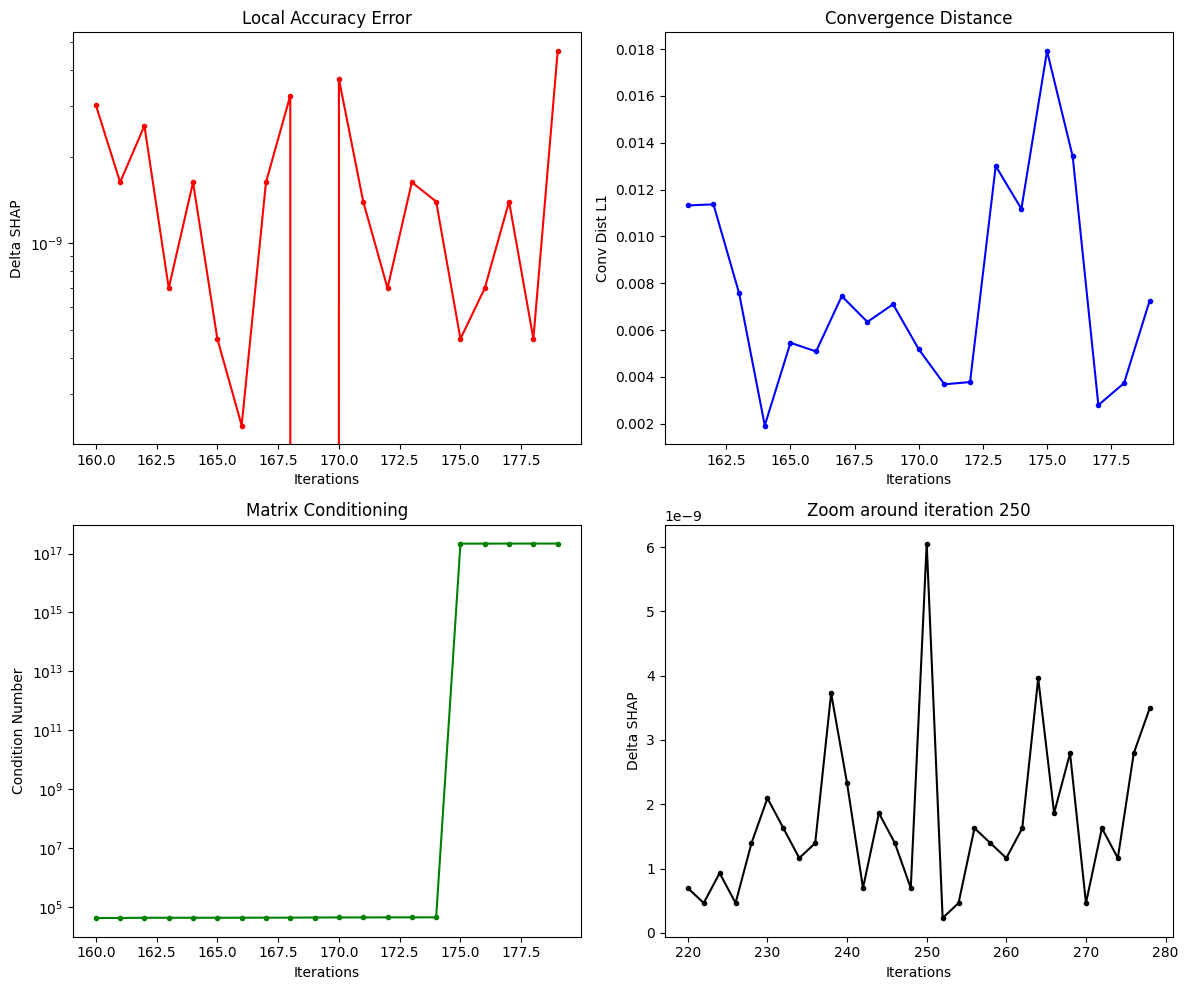


=== Additional Analysis ===
Number of unique samples: 1950
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 176
Samples with exactly 5 features active: 34
Samples with exactly 10 features active: 19
Samples with exactly 50 features active: 2
Samples with exactly 100 features active: 1
Samples with exactly 383 features active: 149

=== Samples around position 170 ===
Sample 160: sum=383, y=0.007214, w=1
Sample 161: sum=363, y=0.006553, w=1
Sample 162: sum=56, y=0.000000, w=1
Sample 163: sum=272, y=0.005593, w=1
Sample 164: sum=122, y=0.001498, w=1
Sample 165: sum=2, y=0.000000, w=1
Sample 166: sum=333, y=0.007090, w=1
Sample 167: sum=156, y=0.005760, w=1
Sample 168: sum=340, y=0.006493, w=1
Sample 169: sum=380, y=0.007226, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=1, y=0.000000, w=1
Sample 172: sum=339, y=0.007196, w=1
Sample 173: sum=46, y=0.000000, w=1
Sample 174: sum=383, y=0.007214, w=1
Sampl

In [ ]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Investigate around iteration 250
print("\n=== Investigating around iteration 250==")
window = list(range(220, 280, 2))  # every 2 iterations to save time
deltas_window = []
for n in window:
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    delta = abs(y[0].item() - (phi0 + phis.sum().item()))
    deltas_window.append(delta)

axes[1,1].plot(window, deltas_window, 'k.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Delta SHAP')
axes[1,1].set_title('Zoom around iteration 250')

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):
    print(f"Sample {i}: sum={X[i].sum():.0f}, y={y[i]:.6f}, w={w[i]:.0f}")

# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [8]:
print("174th sample: ", X[174], y[174].item(), w[174].item())


174th sample:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1

In [9]:
print("index of the only 0 feature: ", (X[174] == 0).nonzero(as_tuple=True)[0].item())

index of the only 0 feature:  299



n=   1: phi299=0.000000, phi0=0.007214, sum(phis)=0.000000

n=   6: phi299=0.000016, phi0=0.000000, sum(phis)=0.007214

n=  11: phi299=0.000029, phi0=-0.000000, sum(phis)=0.007214

n=  16: phi299=0.000014, phi0=-0.000000, sum(phis)=0.007214

n=  21: phi299=0.000014, phi0=-0.000000, sum(phis)=0.007214

n=  26: phi299=0.000021, phi0=0.000000, sum(phis)=0.007214

n=  31: phi299=-0.000020, phi0=0.000000, sum(phis)=0.007214

n=  36: phi299=-0.000018, phi0=0.000000, sum(phis)=0.007214

n=  41: phi299=-0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  46: phi299=-0.000017, phi0=0.000000, sum(phis)=0.007214

n=  51: phi299=-0.000003, phi0=-0.000000, sum(phis)=0.007214

n=  56: phi299=-0.000007, phi0=-0.000000, sum(phis)=0.007214

n=  61: phi299=-0.000003, phi0=-0.000000, sum(phis)=0.007214

n=  66: phi299=-0.000008, phi0=0.000000, sum(phis)=0.007214

n=  71: phi299=-0.000044, phi0=-0.000000, sum(phis)=0.007214

n=  76: phi299=-0.000047, phi0=-0.000000, sum(phis)=0.007214

n=  81: phi299=-0.00

Text(0.5, 1.0, 'Coefficient of 299th feature over iterations')

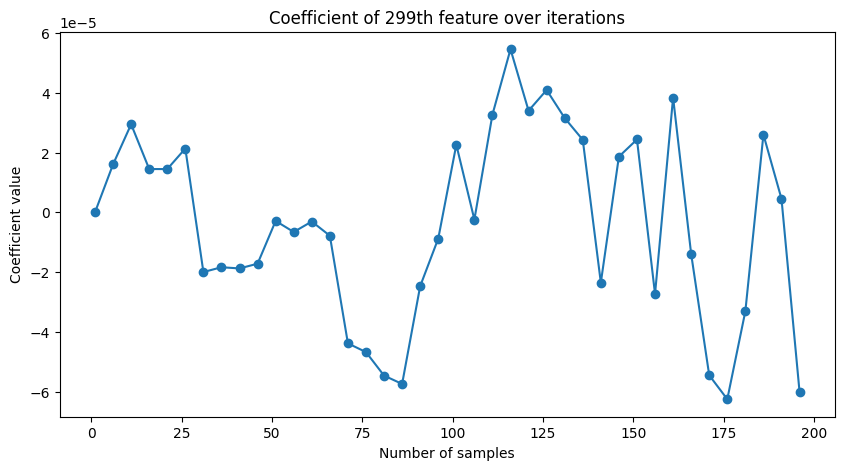

In [ ]:
# examine model weight of the 299th feature from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phi299={phis[299].item():.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save\ the coefficient of the 299th feature
    phis_v.append(phis[299].item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Coefficient of 299th feature over iterations')


n=   1: phiavg=0.000000, phi0=0.007214, sum(phis)=0.000000

n=   6: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  11: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  16: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  21: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  26: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  31: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  36: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  41: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  46: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  51: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  56: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  61: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  66: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  71: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  76: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  81: phiavg=0.000019, phi0=

Text(0.5, 1.0, 'Average coefficient of features over iterations')

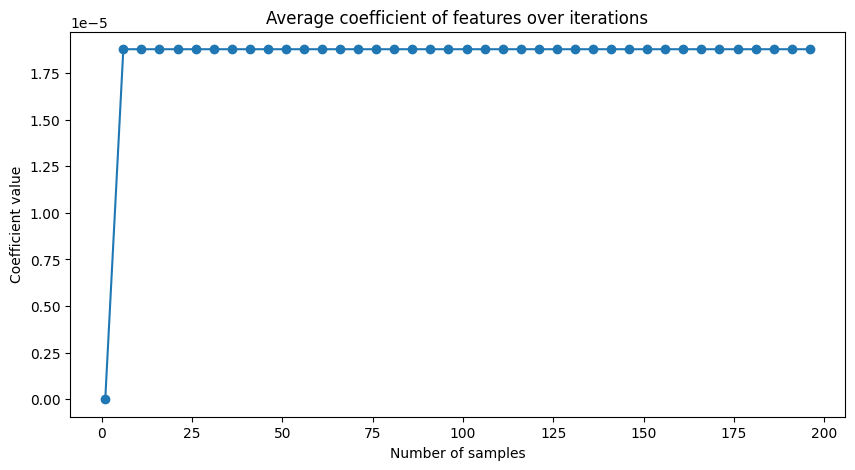

In [ ]:
# examine model weight of the average of the features from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phiavg={phis.mean().item():.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save the average coefficient
    phis_v.append(phis.mean().item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Average coefficient of features over iterations')


n=   6: phi299=0.000016, phi0=0.000000, sum(phis)=0.007214

n=  11: phi299=0.000013, phi0=-0.000000, sum(phis)=0.007214

n=  16: phi299=-0.000015, phi0=-0.000000, sum(phis)=0.007214

n=  21: phi299=-0.000000, phi0=-0.000000, sum(phis)=0.007214

n=  26: phi299=0.000007, phi0=0.000000, sum(phis)=0.007214

n=  31: phi299=-0.000041, phi0=0.000000, sum(phis)=0.007214

n=  36: phi299=0.000002, phi0=0.000000, sum(phis)=0.007214

n=  41: phi299=-0.000000, phi0=-0.000000, sum(phis)=0.007214

n=  46: phi299=0.000002, phi0=0.000000, sum(phis)=0.007214

n=  51: phi299=0.000014, phi0=-0.000000, sum(phis)=0.007214

n=  56: phi299=-0.000004, phi0=-0.000000, sum(phis)=0.007214

n=  61: phi299=0.000004, phi0=-0.000000, sum(phis)=0.007214

n=  66: phi299=-0.000005, phi0=0.000000, sum(phis)=0.007214

n=  71: phi299=-0.000036, phi0=-0.000000, sum(phis)=0.007214

n=  76: phi299=-0.000003, phi0=-0.000000, sum(phis)=0.007214

n=  81: phi299=-0.000008, phi0=0.000000, sum(phis)=0.007214

n=  86: phi299=-0.000

Text(0.5, 1.0, 'Variation of the coefficient of 299th feature over iterations')

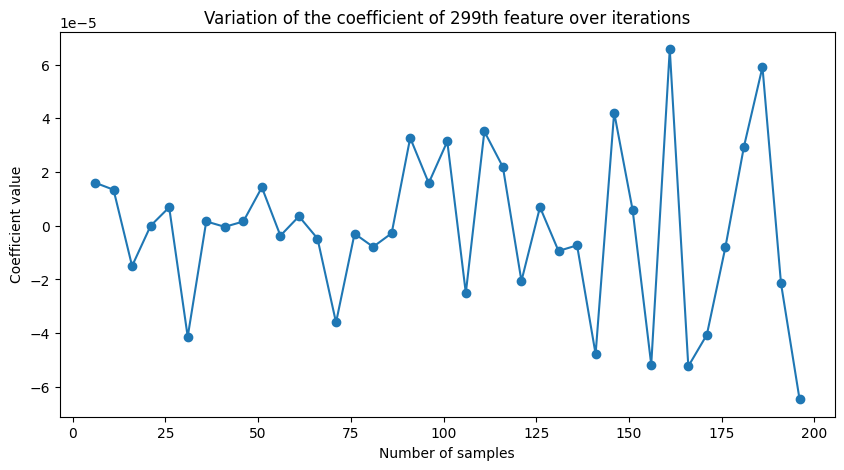

In [ ]:
# examine model weight differences of the features from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
idx = 299  # index of the feature to analyze
phi_prev = None
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    if phi_prev is not None:
        phi = phis[idx] - phi_prev
        print(f"\nn={n:4d}: phi299={phi:.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

        # save the coefficient of the 299th feature
        phis_v.append(phi.item())
    
    phi_prev = phis[idx].clone()

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints[1:], phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Variation of the coefficient of 299th feature over iterations')